In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
    sys.path.append("AITech-forecasting")
    os.system("git clone https://github.com/DominikHuss/AITech-forecasting.git; \
               cd AITech-forecasting; \
               git checkout dev; \
               pip install -r requirements.txt")

In [1]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

In [2]:
def loss_fn(w, X, Y):
    return jnp.mean((jnp.dot(X,w)-Y)**2)

def init(X):
    return jnp.ones((X.shape[1],)) * 0.1

@jax.jit
def update(X, Y, w, lr):
    loss, grads = jax.value_and_grad(loss_fn)(w,X,Y)
    new_w = w - lr*grads
    return new_w, loss

def fit_linear_prophet(X, Y, lr, epochs):
    w = init(X)
    for _ in range(epochs):
        w, loss = update(X,Y,w,lr)
    print(loss)
    return w

def infer_linear_prophet(X, w):
    return X@w

In [3]:
from functions.generate import get_generator, generate_time_series

key = jax.random.PRNGKey(2137)
_, A = get_generator()
Y, w = generate_time_series(key, A, batch_size=10)

/home/dhuss/miniconda3/envs/AITech/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
def get_trend_matrix(T, S):
    step = T/(S+1)
    s = jnp.arange(start=0, stop=T, step=step).astype(int)[1:]
    f = jax.vmap(lambda x: jnp.where(jnp.arange(T) >= x, jnp.ones(T), jnp.zeros(T)), 0, 0)
    A = f(s).T

    t = jnp.arange(T)
    k = t[:, jnp.newaxis]
    m = jnp.ones_like(k)

    A = A*(t[:, jnp.newaxis]-s)
    X = jnp.concatenate((A, k, m), axis=1)/T
    return X, s

In [16]:
def get_future_trend_matrix(T, S, s, T_train_max):
    A = jnp.ones((T-T_train_max, S))

    t = jnp.arange(T_train_max, T)
    k = t[:, jnp.newaxis]
    m = jnp.ones_like(k)

    A = A*(t[:, jnp.newaxis]-s)
    X = jnp.concatenate((A, k, m), axis=1)/T_train_max
    return X

In [17]:
X_T, s = get_trend_matrix(300, 2)

w_t = fit_linear_prophet(X_T, Y[0], 0.1, 100)

1.045396


In [21]:
X_T_future = get_future_trend_matrix(500, 2, s, 300)

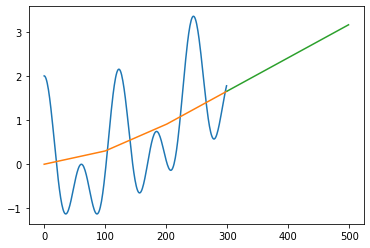

In [22]:
plt.plot(list(range(300)), Y[0])
plt.plot(list(range(300)), jnp.dot(X_T,w_t))
plt.plot(list(range(300, 500)), jnp.dot(X_T_future,w_t))
plt.show()

In [44]:
def get_seasonality_matrix(T, O, *, p=jnp.array([7, 15, 31, 64, 122]), T_train_max = 0):
    x = jnp.arange(T_train_max, T)
    o = jnp.arange(1, O+1)
    arg = 2*jnp.pi*o[:, jnp.newaxis]/p
    arg = x[:, jnp.newaxis]*arg.reshape(arg.size)
    S_X = jnp.concatenate([jnp.sin(arg), jnp.cos(arg)], axis=-1)
    return S_X

def get_future_seasonality_matrix(T, O, T_train_max, *, p=jnp.array([7, 15, 31, 64, 122])):
    return get_seasonality_matrix(T, O, p=p, T_train_max=T_train_max)

In [45]:
X_S = get_seasonality_matrix(300, 3)

w_s = fit_linear_prophet(X_S, Y[0], 0.1, 100)

0.69820744


In [50]:
X_S_future = get_future_seasonality_matrix(500, 3, 300)

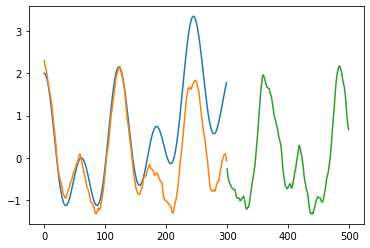

In [51]:
plt.plot(list(range(300)), Y[0])
plt.plot(list(range(300)), jnp.dot(X_S,w_s))
plt.plot(list(range(300, 500)), jnp.dot(X_S_future,w_s))
plt.show()

In [52]:
X_S_T = jnp.concatenate((X_S, X_T), axis=1)

w_s_t = fit_linear_prophet(X_S_T, Y[0], 0.1, 100)

0.033460893


In [54]:
X_S_T_future = jnp.concatenate((X_S_future, X_T_future), axis=1)

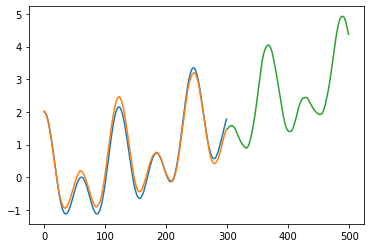

In [55]:
plt.plot(list(range(300)), Y[0])
plt.plot(list(range(300)), jnp.dot(X_S_T,w_s_t))
plt.plot(list(range(300, 500)), jnp.dot(X_S_T_future,w_s_t))
plt.show()

In [28]:
def normal_equation(X, Y):
    hat_matrix = X.T @ X
    print('matrix shape: {}\nmatrix rank: {}'.format(hat_matrix.shape, jnp.linalg.matrix_rank(hat_matrix)))
    return jnp.linalg.inv(X.T @ X) @ X.T @ Y

In [29]:
w_ne = normal_equation(X_S_T, Y[3])

matrix shape: (34, 34)
matrix rank: 33


In [30]:
l, V = jnp.linalg.eig(X_S_T.T @ X_S_T)
l == 0

DeviceArray([False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False,
             False, False, False, False, False, False, False, False,
             False, False], dtype=bool)

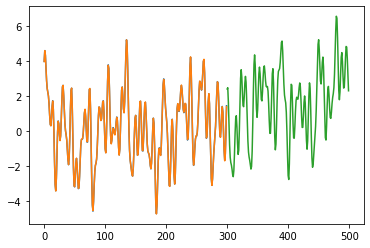

In [56]:
plt.plot(list(range(300)), Y[3])
plt.plot(list(range(300)), jnp.dot(X_S_T,w_ne))
plt.plot(list(range(300, 500)), jnp.dot(X_S_T_future,w_ne))
plt.show()

In [57]:
v_normal_equation = jax.vmap(normal_equation, in_axes=(None, 0), out_axes=0)

W = v_normal_equation(X_S_T, Y)
print(W.shape)

matrix shape: (34, 34)
matrix rank: 33
(10, 34)


In [61]:
batched_Y, batched_w = generate_time_series(key, A, batch_size=100)
batched_W = v_normal_equation(X_S_T, batched_Y)

batched_Y_pred = jnp.einsum("ij,bj->bi", X_S_T, batched_W)
batched_Y_pred_future = jnp.einsum("ij,bj->bi", X_S_T_future, batched_W)

matrix shape: (34, 34)
matrix rank: 33


In [63]:
def plot_all(Y, Y_pred, Y_future):
    n_rows = int(jnp.ceil(Y.shape[0]/4))
    n_cols = 4
    x = list(range(Y.shape[1]))
    x_future = list(range(Y.shape[1], Y.shape[1]+Y_future.shape[1]))
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,20))
    for i in range(Y.shape[0]):
        r = i//4
        c = i%4
        axs[r, c].plot(x, Y[i])
        axs[r, c].plot(x, Y_pred[i])
        axs[r, c].plot(x_future, Y_future[i])
    fig.show()

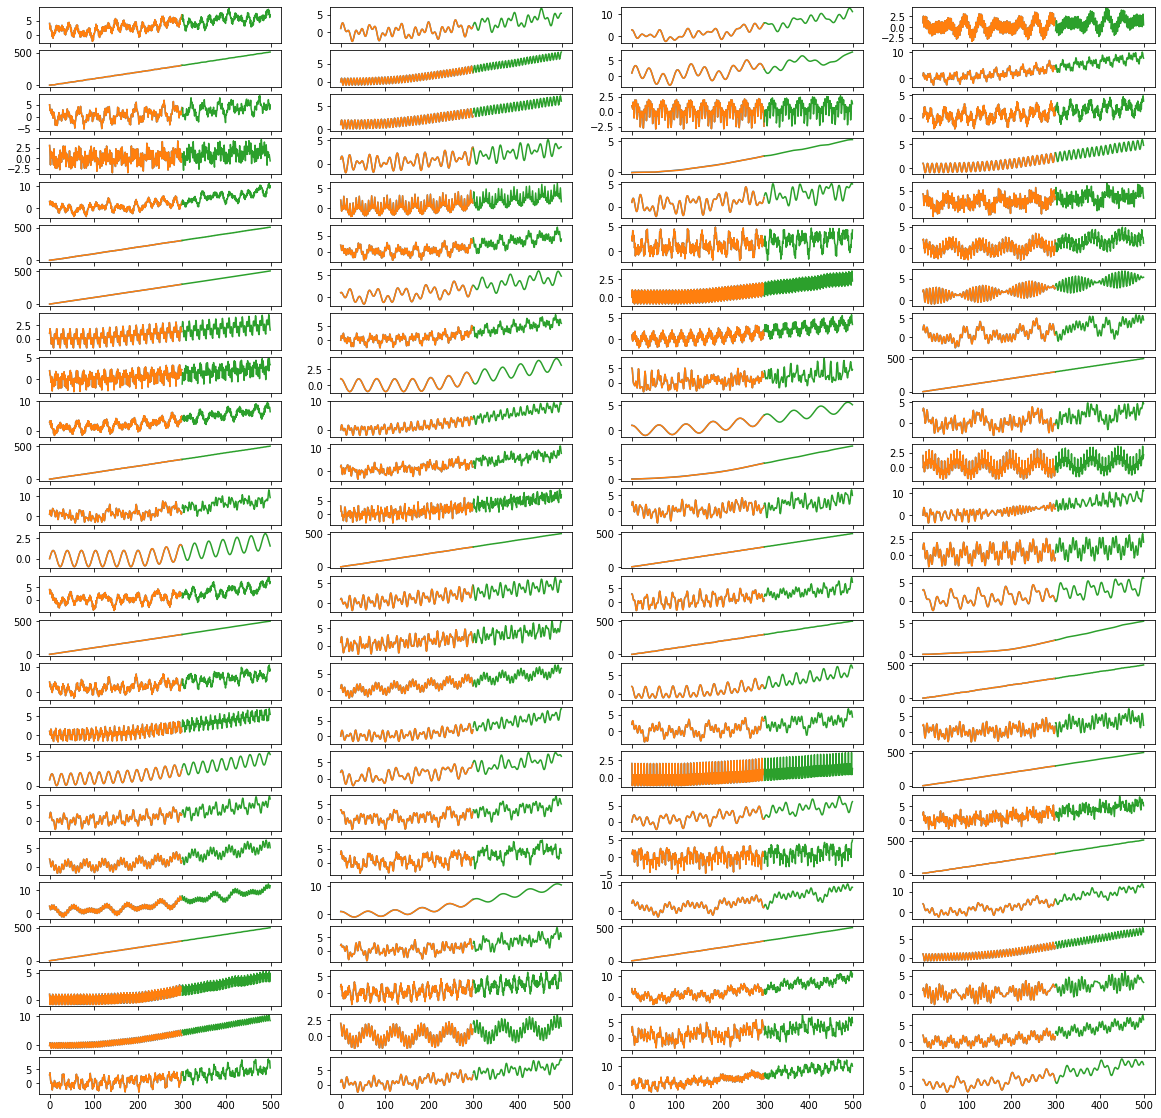

In [64]:
plot_all(batched_Y, batched_Y_pred, batched_Y_pred_future)